## What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?
- Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

## What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

## Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# importing library

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import WordPunctTokenizer 
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# reading dataset

In [142]:
df_train = pd.read_csv(r'C:\Users\home\WorkSpace\kaggle\Real_or_Not\train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv(r'C:\Users\home\WorkSpace\kaggle\Real_or_Not\test.csv', dtype={'id': np.int16})
df_sub = pd.read_csv(r'C:\Users\home\WorkSpace\kaggle\Real_or_Not\sample_submission.csv', dtype={'id': np.int16})

# data exploring&cleaning

In [143]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [144]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


In [145]:
df_train.shape

(7613, 5)

In [146]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB


In [147]:
df_test.shape

(3263, 4)

In [148]:
target_df_train = df_train.groupby('target').target.count()

In [149]:
target_df_train


target
0    4342
1    3271
Name: target, dtype: int64

In [150]:
label = ['disaster', 'non_disaster']

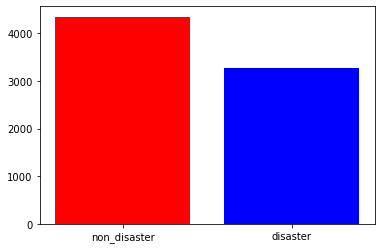

In [151]:
plt.bar(label[1],target_df_train[0], color = 'r')
plt.bar(label[0],target_df_train[1], color = 'b')
plt.show()

이 예제 를 풀려면 텍스트에 대한 분류와 binary classification이 필요할 것 같다. 이 부분에서 공부를 해야할 것 같다. 
텍스트를 통한 KEYWORD분류도 가능할 것 같다. 

# Text cleaning

In [152]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))


# Let's take a look at the updated text
df_train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

# stopwords 제거

In [153]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

df_train['text'] = df_train['text'].apply(lambda x:" ".join(term for term in x.split() if term not in stop_words))
df_test['text'] = df_test['text'].apply(lambda x:" ".join(term for term in x.split() if term not in stop_words))

df_train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

# 토큰화

In [154]:
tokenizer = WordPunctTokenizer()

df_train['text'] = df_train['text'].apply(lambda x: tokenizer.tokenize(x))
df_test['text'] = df_test['text'].apply(lambda x: tokenizer.tokenize(x))

tokens = df_train['text']

In [155]:
token

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                                    [volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

# Stemmer,Lemmatizer

In [156]:
# Stemmer
stemmer = PorterStemmer()

token.lower

df_train['text'] = df_train['text'].apply(lambda x:" ".join(stemmer.stem(token) for token in tokens))
df_test['text'] = df_test['text'].apply(lambda x:" ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=WordNetLemmatizer()

df_train['text'] = df_train['text'].apply(lambda x:" ".join(lemmatizer.lemmatize(token) for token in tokens))
df_test['text'] = df_test['text'].apply(lambda x:" ".join(lemmatizer.lemmatize(token) for token in tokens))

AttributeError: 'Series' object has no attribute 'lower'

In [157]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

df_train['text'] = df_train['text'].apply(lambda x : combine_text(x))
df_test['text'] = df_test['text'].apply(lambda x : combine_text(x))
df_train['text']
df_train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

# BOW

In [158]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_train['text'])
test_vectors = count_vectorizer.transform(df_test['text'])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [159]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test['text'])
print(train_tfidf)

  (0, 6029)	0.4127241670499736
  (0, 10227)	0.23716098275777425
  (0, 3754)	0.42660875382968927
  (0, 217)	0.37358571513536404
  (0, 6028)	0.2646487348216956
  (0, 2897)	0.2959083674601754
  (0, 7879)	0.33504681937478503
  (0, 2414)	0.42660875382968927
  (1, 3589)	0.4781907991017602
  (1, 3744)	0.42162281679203917
  (1, 1417)	0.41675720429854407
  (1, 5351)	0.3757141854237119
  (1, 6530)	0.33265029752231373
  (1, 3570)	0.2511337989166678
  (1, 3743)	0.32403030437201963
  (2, 3253)	0.2580872844705925
  (2, 6970)	0.2684495282245868
  (2, 3168)	0.2177728140293216
  (2, 6832)	0.2830542905170327
  (2, 7328)	0.48119880358519396
  (2, 8655)	0.586833068542054
  (2, 544)	0.2788117719785811
  (2, 8061)	0.2830542905170327
  (3, 3176)	0.4706106619990253
  (3, 1369)	0.2764742850446076
  :	:
  (7611, 7477)	0.20005204986869024
  (7611, 2924)	0.4001040997373805
  (7611, 1876)	0.1397909095273928
  (7611, 9690)	0.184364364714822
  (7611, 4977)	0.16216570194521843
  (7611, 8568)	0.16518785727442115
  (76

In [160]:
from sklearn.model_selection import train_test_split

seed = 42

X = df_train.text
y = df_train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [162]:
# accuracy score function

def acc_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
   
    print("-"*30)
    
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    
    print("-"*30)
    
    return accuracy

In [163]:
# some model and their performance

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "Bernouli", "PassiveAggressiveClassifier",
     "Naive Bayes", "SVC"]

classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(n_estimators=100),
    LogisticRegression(),
    MultinomialNB(),
    BernoulliNB(),
    PassiveAggressiveClassifier(max_iter=50),
    SVC(kernel="linear")
]
    
zipped_clf = zip(names, classifiers)
tvec = TfidfVectorizer()
    
def compare_clf(classifier=zipped_clf, vectorizer=tvec, n_features=10000, ngram_range=(1, 1)):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n, c in classifier:
        checker_pipeline = Pipeline([
            ("vectorizer", vectorizer),
            ("classifier", c)
        ])
        clf_acc = acc_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        print("Model result for {}".format(n))
        print(c)
        result.append((n, clf_acc))
    return result

In [164]:
trigram_result = compare_clf()

------------------------------
accuracy score: 67.29%
------------------------------
Model result for K Nearest Neighbors
KNeighborsClassifier(n_neighbors=3)
------------------------------
accuracy score: 72.15%
------------------------------
Model result for Decision Tree
DecisionTreeClassifier(random_state=0)
------------------------------
accuracy score: 77.58%
------------------------------
Model result for Random Forest
RandomForestClassifier()
------------------------------
accuracy score: 80.78%
------------------------------
Model result for Logistic Regression
LogisticRegression()
------------------------------
accuracy score: 80.34%
------------------------------
Model result for Bernouli
MultinomialNB()
------------------------------
accuracy score: 80.52%
------------------------------
Model result for PassiveAggressiveClassifier
BernoulliNB()
------------------------------
accuracy score: 74.17%
------------------------------
Model result for Naive Bayes
PassiveAggressiveC

In [165]:
trigram_result

[('K Nearest Neighbors', 0.6729422066549913),
 ('Decision Tree', 0.7215411558669002),
 ('Random Forest', 0.7758318739054291),
 ('Logistic Regression', 0.8077933450087565),
 ('Bernouli', 0.803415061295972),
 ('PassiveAggressiveClassifier', 0.8051663747810858),
 ('Naive Bayes', 0.7416812609457093),
 ('SVC', 0.8003502626970228)]

In [166]:
# prediction

def prediction(pipeline, testtext):
    sentiment_fit = pipeline.fit(X_train,y_train)
    y_pred = sentiment_fit.predict(testtext)
    
    return y_pred

In [167]:
index = df_test.id
newFrame = pd.DataFrame({"id":index, "target":prediction})
newFrame.to_csv("Real_or_Not_machine learning.csv", index=False)

# Logistic Regression

In [168]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(train_vectors, df_train["target"])
pred1 = clf.predict(train_vectors)
accuracy_score(df_train["target"],pred1)

0.9565217391304348

In [171]:
clf_tfidf = LogisticRegression(C=1.0)
clf_tfidf.fit(train_tfidf, df_train["target"])
pred2 = clf.predict(train_tfidf)
accuracy_score(df_train["target"],pred2)

0.8802049126494155

# Naives Bayes Classifier

In [176]:
clf_NB = MultinomialNB()
clf_NB.fit(train_vectors, df_train["target"])
pred3 = clf_NB.predict(train_vectors)
accuracy_score(df_train["target"],pred3)

0.9129121239984237

In [180]:
clf_NB_TFIDF = MultinomialNB()
clf_NB_TFIDF.fit(train_tfidf, df_train["target"])
pred4 = clf_NB.predict(train_tfidf)
accuracy_score(df_train["target"],pred4)

0.8674635491921713

# XGBOOST

In [207]:
clf_xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf_xgb.fit(train_vectors, df_train["target"])
pred5 = clf_xgb.predict(train_vectors)
accuracy_score(df_train["target"],pred5)

0.8161040325758571

In [208]:
train_tfidf = df_train.values
test_tfidf = df_test.values

In [209]:
clf_xgb_TFIDF = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf_xgb_TFIDF.fit(train_tfidf, df_train["target"])
pred6 = clf_xgb_TFIDF.predict(train_vectors)
accuracy_score(df_train["target"],pred6)

ValueError: could not convert string to float: 'deeds reason earthquake may allah forgive us'

In [210]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [214]:
submission_file_path = r"C:\Users\home\WorkSpace\kaggle\Real_or_Not\sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)

ValueError: could not convert string to float: 'ablaze'